In [6]:
# Uncomment to download libraries.
# %pip install findpeaks
# %pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from findpeaks import findpeaks
sns.set_theme()
sns.set(rc={'figure.figsize':(35,15)})

> ## Cálculo dos thresholds usados para classificação de picos:

In [4]:
# Reading 1st file: 00000.txt
df = pd.read_fwf(filepath_or_buffer = 'Dados citómetro/D1_5ul/00000.txt', header = None, usecols = [0, 1, 2],
    names = ['t', 's1', 's2'], engine = 'c', dtype =  {'t': np.float32, 's1': np.float32, 's2': np.float32})

# Removing some points that weren't part of the noise?
df = df.loc[df['t'] < 6]

# Computing threshold values for peak and valley detection:
THRESHOLD_MAX = np.max(df['s1'])
THRESHOLD_MIN = np.min(df['s1'])
print(f'THRESHOLD_MAX = {THRESHOLD_MAX}\nTHRESHOLD_MIN = {THRESHOLD_MIN}')
# print(sum(df['s1'])/len(df['s1']))

THRESHOLD_MAX = 3.700312663568184e-05
THRESHOLD_MIN = -3.123521673842333e-05


> ## Ler ficheiros 35, 36 e 37, onde há vários picos:

In [25]:
# Ler ficheiros 35, 36, 37 e concatenar:
df_array = []
files = ['Dados citómetro/D1_5ul/000' + str(i) + '.txt' for i in range(35,36)] # Mudei isto! Estou a ler apenas o 35!
print(files)
for file in files:
    df_array.append(pd.read_fwf(filepath_or_buffer = file, header = None, usecols = [0, 1, 2],
    names = ['t', 's1', 's2'], engine = 'c', dtype =  {'t': np.float32, 's1': np.float32, 's2': np.float32}))
df_relevant = pd.concat(df_array, axis=0, ignore_index=True)

['Dados citómetro/D1_5ul/00035.txt']


> ## Graphing for visualization:

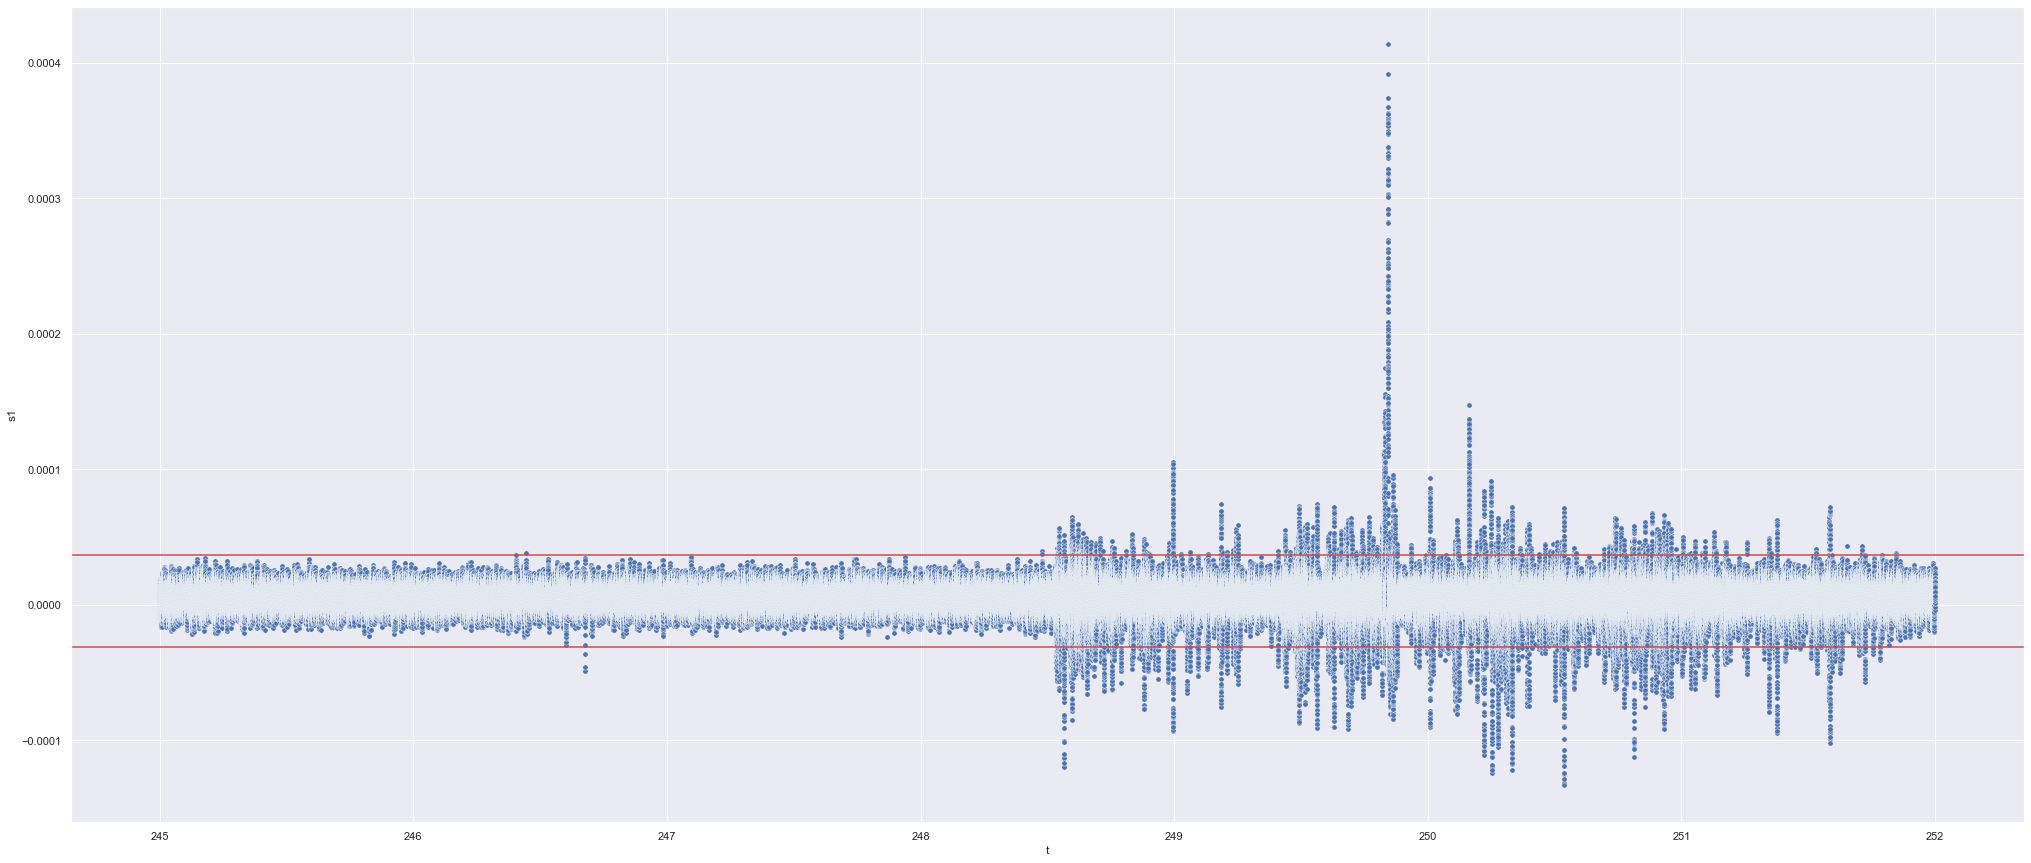

In [26]:
# Plotting graph corresponding to files 35, 36 and 37:
fig1 = sns.scatterplot(data = df_relevant, x="t", y='s1', s=28)

# Plotting threshold lines:
plt.axhline(y = THRESHOLD_MAX, color = 'r', linestyle = '-')
plt.axhline(y = THRESHOLD_MIN, color = 'r', linestyle = '-')

> ## Applying FIR filter to smooth out the graph:

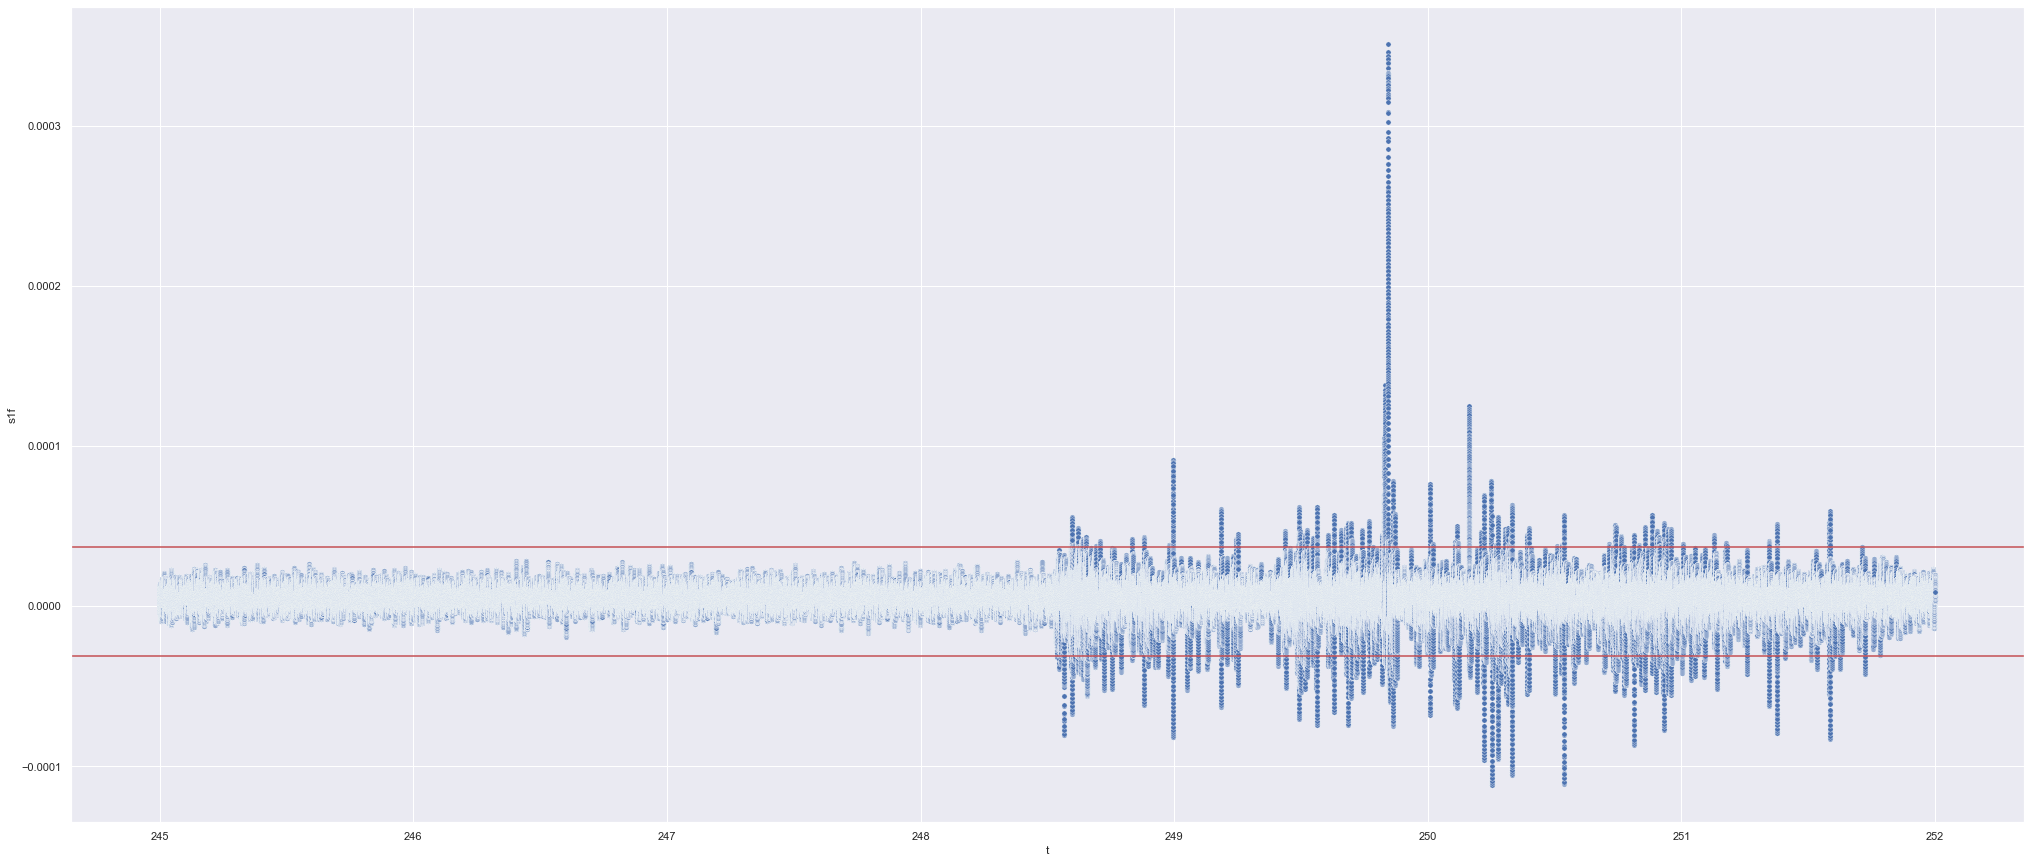

In [27]:
import scipy.signal as sg

# Filter:
b1 = sg.get_window('boxcar', 20) # Try 'boxcar' window for moving average! I had 'triang' before! 10->20!
                                 # Faz a moving average de 20 pontos, com 'boxcar'.
# Applying filter to smooth out the curve:
fil = sg.convolve(df_relevant['s1'], b1 / b1.sum())

d = {'t': df_relevant['t'], 's1f': fil[:len(df_relevant['t'])]}
df_relevant_filtered = pd.DataFrame(data=d)
# Sensor 1:
fig2 = sns.scatterplot(data = df_relevant_filtered, x="t", y='s1f', s=28)

# Plotting threshold lines:
plt.axhline(y = THRESHOLD_MAX, color = 'r', linestyle = '-')
plt.axhline(y = THRESHOLD_MIN, color = 'r', linestyle = '-')

> ## Using 'findpeaks' library to find peaks:

In [28]:
# Using findpeaks library:
fp = findpeaks(method='peakdetect', lookahead=200 ,interpolate=20)
peaks_array = df_relevant_filtered['s1f'].to_numpy()
results = fp.fit(peaks_array)

# Plotting result:
# fp.plot()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Interpolating 1d-vector by factor 20


In [29]:
# Number of peaks:
FINAL = results['df_interp'].loc[(results['df_interp']['y'] >= THRESHOLD_MAX) & (results['df_interp']['peak'] == True)]
NPeaks = sum((results['df_interp']['y'] > THRESHOLD_MAX) & (results['df_interp']['peak'] == True))
print(f'Number of peaks = {NPeaks}')

# Number of valleys
FINAL2 = results['df_interp'].loc[(results['df_interp']['y'] <= THRESHOLD_MIN) & (results['df_interp']['valley'] == True)]
NValleys = sum((results['df_interp']['y'] < THRESHOLD_MIN) & (results['df_interp']['valley'] == True)) 
print(f'Number of valleys = {NValleys}')

Number of peaks = 100
Number of valleys = 219


> ## Plotting final result:

In [30]:
# Peaks x values:
abcissaPeaks = np.rint(FINAL['x'].to_numpy()/20)
abcissaPeaks = abcissaPeaks.astype(int)
abcissaPeaks = [df_relevant_filtered['t'].iloc[i] for i in abcissaPeaks]
# print(f'Abcissas valores (peaks) = {abcissaPeaks}')

# Valleys x values:
abcissaValleys = np.rint(FINAL2['x'].to_numpy()/20)
abcissaValleys = abcissaValleys.astype(int)
abcissaValleys = [df_relevant_filtered['t'].iloc[i] for i in abcissaValleys]
# print(f'Abcissas valores (valleys) = {abcissaValleys}')

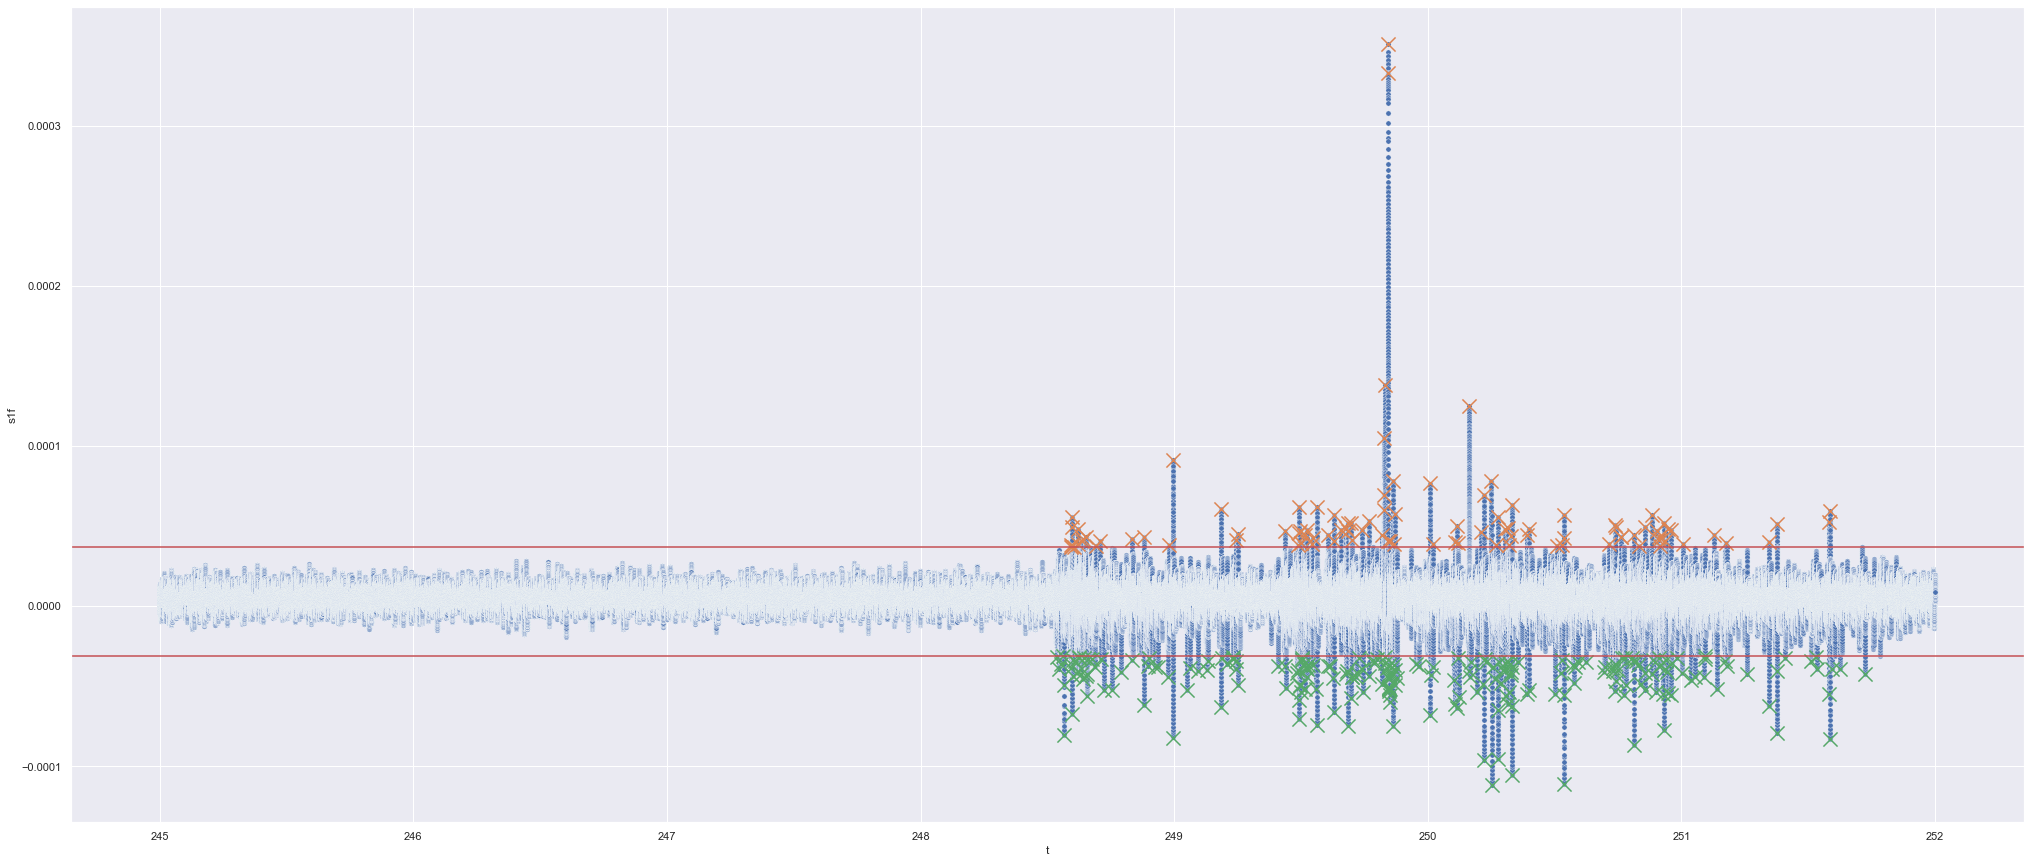

In [31]:
# Sensor 1:
fig3 = sns.scatterplot(data = df_relevant_filtered, x="t", y='s1f', s=28)

# Plotting threshold lines:
plt.axhline(y = THRESHOLD_MAX, color = 'r', linestyle = '-')
plt.axhline(y = THRESHOLD_MIN, color = 'r', linestyle = '-')

plt.scatter(x = abcissaPeaks, y = FINAL['y'], marker = "x", s = 200)
plt.scatter(x = abcissaValleys, y = FINAL2['y'], marker = "x", s = 200)

> ## Now, without the FIR filter:

> ## Using 'findpeaks':

In [32]:
# Using findpeaks library:
fp = findpeaks(method='peakdetect', lookahead=200 ,interpolate=20)
peaks_array = df_relevant['s1'].to_numpy()
results = fp.fit(peaks_array)

# Plotting result:
# fp.plot()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Interpolating 1d-vector by factor 20


> ## Number of peaks and valleys:

In [33]:
# Number of peaks:
FINAL = results['df_interp'].loc[(results['df_interp']['y'] >= THRESHOLD_MAX) & (results['df_interp']['peak'] == True)]
NPeaks = sum((results['df_interp']['y'] > THRESHOLD_MAX) & (results['df_interp']['peak'] == True))
print(f'Number of peaks = {NPeaks}')

# Number of valleys
FINAL2 = results['df_interp'].loc[(results['df_interp']['y'] <= THRESHOLD_MIN) & (results['df_interp']['valley'] == True)]
NValleys = sum((results['df_interp']['y'] < THRESHOLD_MIN) & (results['df_interp']['valley'] == True)) 
print(f'Number of valleys = {NValleys}')

Number of peaks = 284
Number of valleys = 462


> ## Plotting results without the FIR filter:

In [34]:
# Peaks x values:
abcissaPeaks = np.rint(FINAL['x'].to_numpy()/20)
abcissaPeaks = abcissaPeaks.astype(int)
abcissaPeaks = [df_relevant['t'].iloc[i] for i in abcissaPeaks]
# print(f'Abcissas valores (peaks) = {abcissaPeaks}')

# Valleys x values:
abcissaValleys = np.rint(FINAL2['x'].to_numpy()/20)
abcissaValleys = abcissaValleys.astype(int)
abcissaValleys = [df_relevant['t'].iloc[i] for i in abcissaValleys]
# print(f'Abcissas valores (valleys) = {abcissaValleys}')

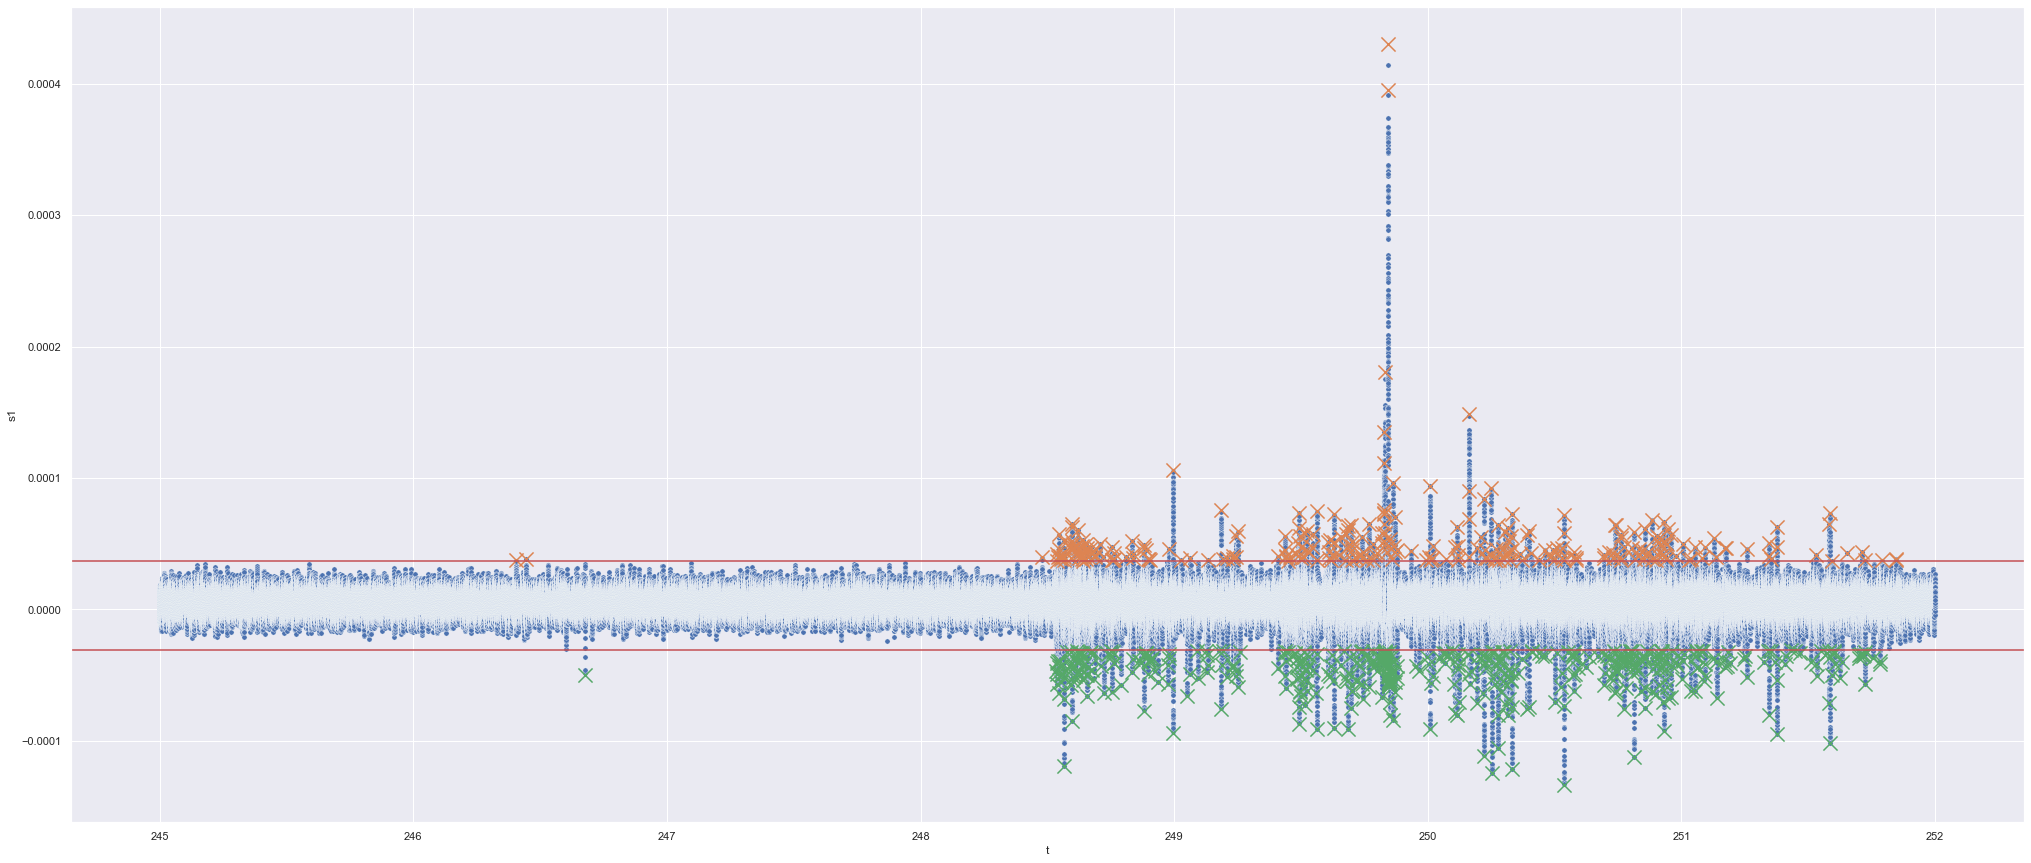

In [35]:
# Sensor 1:
fig3 = sns.scatterplot(data = df_relevant, x="t", y='s1', s=28)

# Plotting threshold lines:
plt.axhline(y = THRESHOLD_MAX, color = 'r', linestyle = '-')
plt.axhline(y = THRESHOLD_MIN, color = 'r', linestyle = '-')

plt.scatter(x = abcissaPeaks, y = FINAL['y'], marker = "x", s = 200)
plt.scatter(x = abcissaValleys, y = FINAL2['y'], marker = "x", s = 200)